In [65]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy import  ndimage

warnings.filterwarnings("ignore")

# LAB 2

### Retall de sub-imatges

In [66]:
def llegir_retallar(nombre_archivo):
    img = cv2.imread('imgs/' + str(nombre_archivo) + '.jpg', cv2.COLOR_BGR2GRAY)
    img1 = img[:img.shape[0]//3, :]
    img2 = img[img.shape[0]//3:(img.shape[0]//3)*2, :]
    img3 = img[(img.shape[0]//3)*2:, :]
    #plt.imshow(img1, cmap='gray')
    #plt.imshow(img2, cmap='gray')
    #plt.imshow(img3, cmap='gray')
    return [img1, img2, img3]





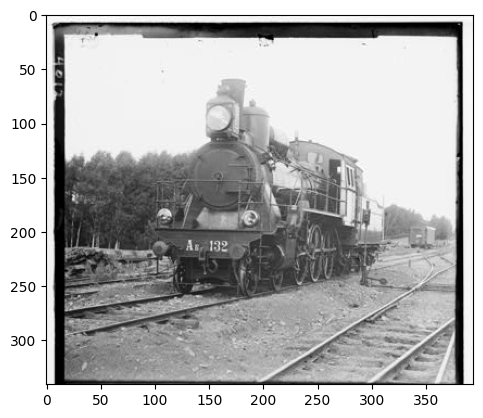

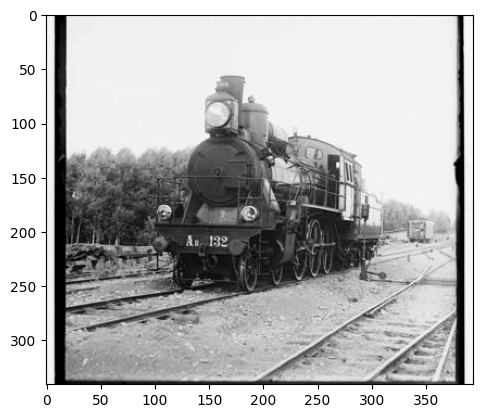

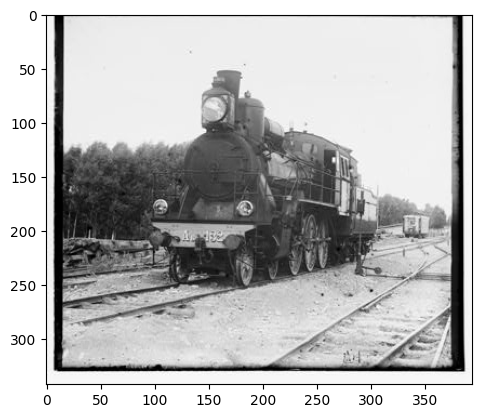

In [67]:
archivos = os.listdir('imgs')
archivos = [a.removesuffix('.jpg') for a in archivos if a.endswith('.jpg')]


def llegir_imatges(archivos):
    images = {}
    for i in archivos:
        img = llegir_retallar(i)
        images[i] = img
    return images
images = llegir_imatges(archivos)


plt.imshow(images[archivos[1]][0], cmap='gray')
plt.show()
plt.imshow(images[archivos[1]][1], cmap='gray')
plt.show()
plt.imshow(images[archivos[1]][2], cmap='gray')
plt.show()
    


In [68]:
def recortar_marcos(img):
    gauss = cv2.GaussianBlur(img, (5,5), 0)
    _, binarizada = cv2.threshold(gauss, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    contornos, _ = cv2.findContours(binarizada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    mayor_contorno = max(contornos, key=cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(mayor_contorno)
    
    imagen_recortada = img[y:y+h, x:x+w]
    
    return imagen_recortada

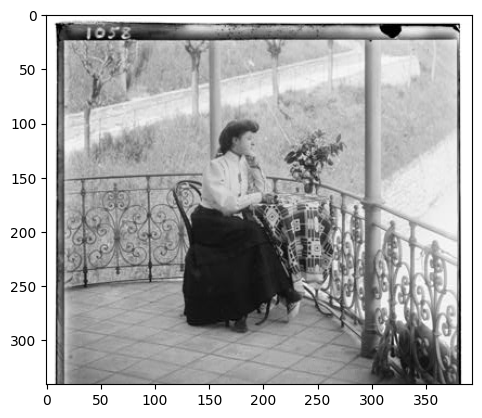

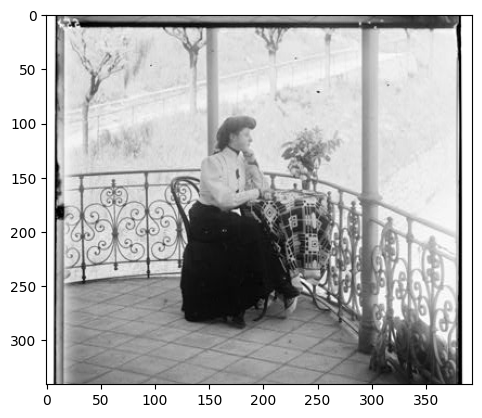

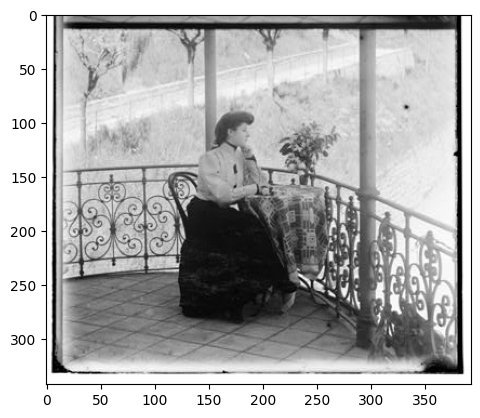

In [69]:

imagen1  = np.array(images[archivos[2]][0])
imagen2  = np.array(images[archivos[2]][1])
imagen3  = np.array(images[archivos[2]][2])
plt.imshow(imagen1, cmap='gray')
plt.show()
plt.imshow(imagen2, cmap='gray')
plt.show()
plt.imshow(imagen3, cmap='gray')
plt.show()

In [70]:
print(imagen1.shape, imagen2.shape, imagen3.shape)

(341, 393) (341, 393) (342, 393)


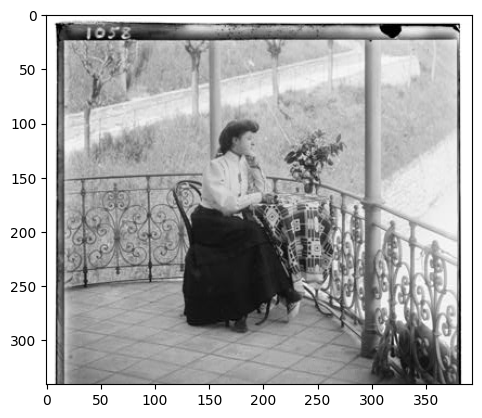

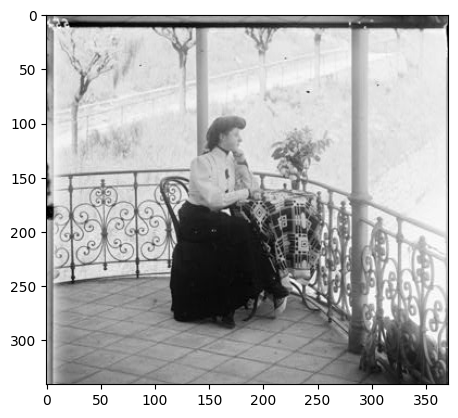

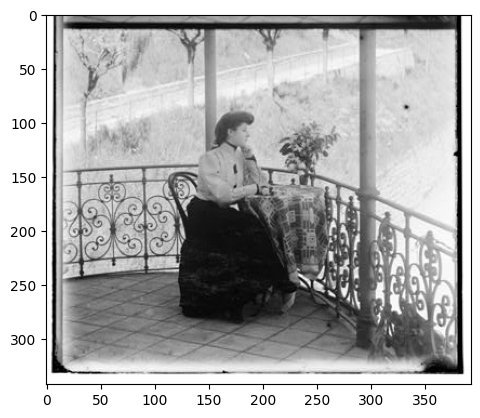

In [71]:
imagen1 = recortar_marcos(imagen1)
imagen2 = recortar_marcos(imagen2)
imagen3 = recortar_marcos(imagen3)
plt.imshow(imagen1, cmap='gray')
plt.show()
plt.imshow(imagen2, cmap='gray')
plt.show()
plt.imshow(imagen3, cmap='gray')
plt.show()

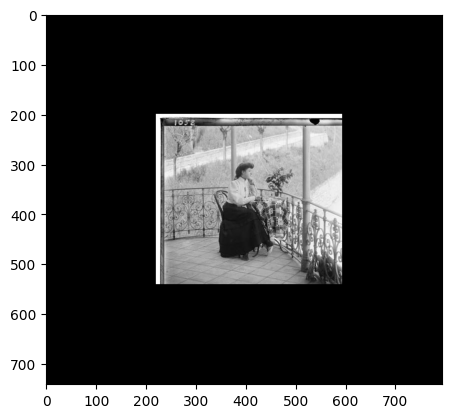

In [72]:
imagen1_desplazada = np.roll(imagen1, 20, axis=1)
imagen1_desplazada[:, :20] = 0
imagen1_desplazada = cv2.copyMakeBorder(imagen1_desplazada, 200, 200, 200, 200, cv2.BORDER_CONSTANT)

plt.imshow(imagen1_desplazada, cmap='gray')
plt.show()

(341, 393) (401, 401)


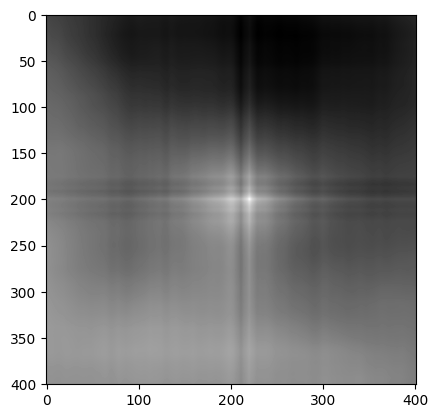

In [73]:
resultado_correlacion = cv2.matchTemplate(imagen1_desplazada, imagen1, cv2.TM_CCOEFF_NORMED)
print(imagen1.shape, resultado_correlacion.shape)
plt.imshow(resultado_correlacion, cmap='gray')
plt.show()


In [74]:
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(resultado_correlacion)
max_val, max_loc


(0.7212127447128296, (220, 200))

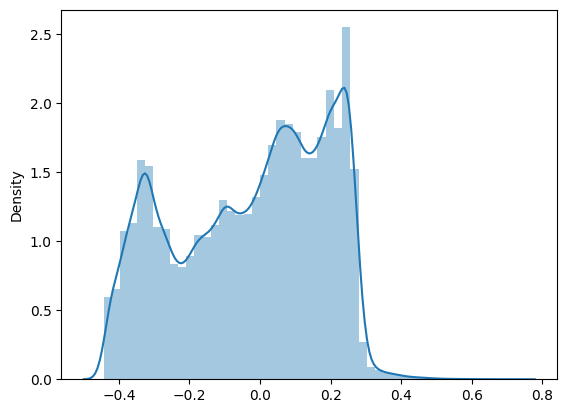

In [75]:
sns.distplot(resultado_correlacion.flatten())
plt.show()

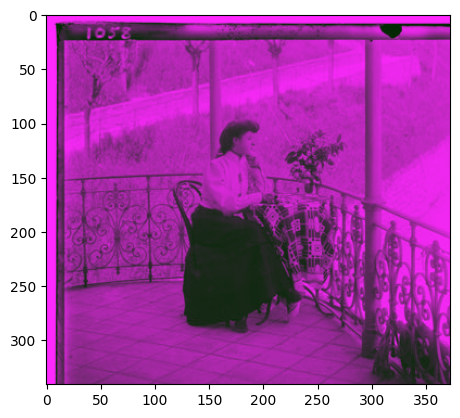

In [76]:
res = np.copy(imagen1_desplazada)
res = np.reshape(res, (res.shape[0], res.shape[1], 1))
res = np.concatenate([res, res, res], axis=2)

h, w = imagen1.shape[:2]
x = max_loc[0]
y = max_loc[1]
    
res[y:y+h, x:x+w,1] = 40

plt.imshow(res[200:-(200), 200 + 20:-(200), :])

### Funcion para alinear imagenes

In [77]:
CORRELACION_BASADA_CONVOlUCÍON = 0
CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA = 1
CORRELACION_BASADA_FOURIER = 2
CORRELACION_BASADA_ESPAI_FOURIER = 3

In [78]:
def calMax(imagen1, imagen2, imagen3):
    if(imagen1.shape[0]*imagen1.shape[1] > imagen2.shape[0]*imagen2.shape[1] and imagen1.shape[0]*imagen1.shape[1] > imagen3.shape[0]*imagen3.shape[1]):
        return 1
    elif(imagen2.shape[0]*imagen2.shape[1] > imagen3.shape[0]*imagen3.shape[1]):
        return 2
    else:
        return 3

In [213]:
def alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA):
        
    altura_img, ancho_img = imagen1.shape[:2]
    altura_plantilla, ancho_plantilla = imagen2.shape[:2]
    print(altura_img, ancho_img, altura_plantilla, ancho_plantilla)
    pad_alto = altura_plantilla - 1
    pad_ancho = ancho_plantilla - 1

    imagen_padded = cv2.copyMakeBorder(imagen1, pad_alto, pad_alto, pad_ancho, pad_ancho, cv2.BORDER_CONSTANT)

    res = np.copy(imagen_padded)
    res = np.reshape(res, (res.shape[0], res.shape[1], 1))
    res = np.concatenate([res, res, res], axis=2)
    
    #pfimera correlacion, imagen1 con imagen2
    if metodo == CORRELACION_BASADA_CONVOlUCÍON:
        resultado_correlacion1 = cv2.matchTemplate(imagen_padded, imagen2, cv2.TM_CCORR)
        resultado_correlacion2 = cv2.matchTemplate(imagen_padded, imagen3, cv2.TM_CCORR)

    elif metodo == CORRELACION_BASADA_CONVOlUCÍON_NORMALIZADA:
        resultado_correlacion1 = cv2.matchTemplate(imagen_padded, imagen2, cv2.TM_CCORR_NORMED)
        resultado_correlacion2 = cv2.matchTemplate(imagen_padded, imagen3, cv2.TM_CCORR_NORMED)

    elif metodo == CORRELACION_BASADA_ESPAI_FOURIER:
        maxim  = calMax(imagen1, imagen2, imagen3)
        print(imagen1.shape, imagen2.shape, imagen3.shape)
        if maxim == 1:
            plantilla1 =  np.resize(imagen2, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen3, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen1
        elif maxim == 2:
            plantilla1 =  np.resize(imagen1, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen3, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen2
        else:   
            plantilla1 =  np.resize(imagen1, (imagen3.shape[0], imagen3.shape[1]))
            plantilla2 =  np.resize(imagen2, (imagen3.shape[0], imagen3.shape[1]))
            img = imagen3
    
        
        f1 = np.fft.fft2(img)
        f2 = np.fft.fft2(plantilla1)
        inversa = np.fft.ifft2(f1 * np.conj(f2))

        y, x = np.unravel_index(np.argmax(inversa), inversa.shape)

        res = np.copy(img)
        res = np.reshape(res, (res.shape[0], res.shape[1], 1))
        res = np.concatenate([res, res, res], axis=2)

        h, w = plantilla1.shape[:2]
        imagen1_alineada = np.roll(plantilla1, shift=(y, x), axis=(0, 1))


        res[:, :,1] = imagen1_alineada

        f2 = np.fft.fft2(plantilla2)
        inversa = np.fft.ifft2(f1 * np.conj(f2))

        y, x = np.unravel_index(np.argmax(inversa), inversa.shape)

        h, w = plantilla2.shape[:2]
        imagen2_alineada = np.roll(plantilla2, shift=(y, x), axis=(0, 1))


        res[:, :,2] = imagen2_alineada


        return res
        
    _, max_val, _, max_loc = cv2.minMaxLoc(resultado_correlacion1)
    
    print(f'Máximo valor de correlación: {max_val} posiocion: {max_loc}')
    
    h, w = imagen2.shape[:2]
    x = max_loc[0]
    y = max_loc[1]
    
    res[y:y+h, x:x+w,1] = imagen2
    
    _, max_val, _, max_loc = cv2.minMaxLoc(resultado_correlacion2)
    
    print(f'Máximo valor de correlación: {max_val} posiocion: {max_loc}')
    
    h, w = imagen3.shape[:2]
    x = max_loc[0]
    y = max_loc[1]
    
    res[y:y+h, x:x+w,2] = imagen3

    return res[pad_alto:-(pad_alto), pad_ancho:-(pad_ancho), :]

In [214]:
imagen1.shape, imagen2.shape, imagen3.shape

((341, 393), (341, 371), (342, 393))

#### Correlació basada en convloució en l'espai

In [215]:
res = alinear_imagenes(imagen1, imagen2, imagen3)

341 393 341 371
Máximo valor de correlación: 0.9713205695152283 posiocion: (382, 344)
Máximo valor de correlación: 0.9278493523597717 posiocion: (370, 339)


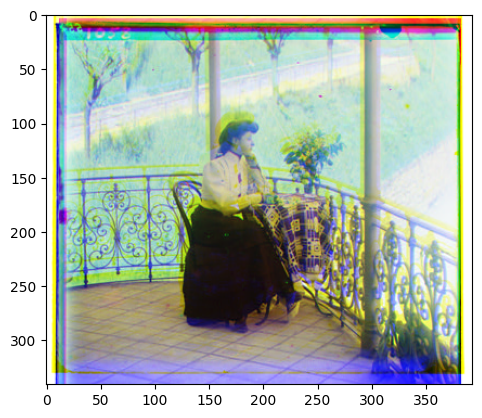

In [216]:
plt.imshow(res)
plt.show()

#### CORRELACIÓ BASADA ESPAI FOURIER

In [217]:
res = alinear_imagenes(imagen1, imagen2, imagen3, metodo=CORRELACION_BASADA_ESPAI_FOURIER)

341 393 341 371
(341, 393) (341, 371) (342, 393)


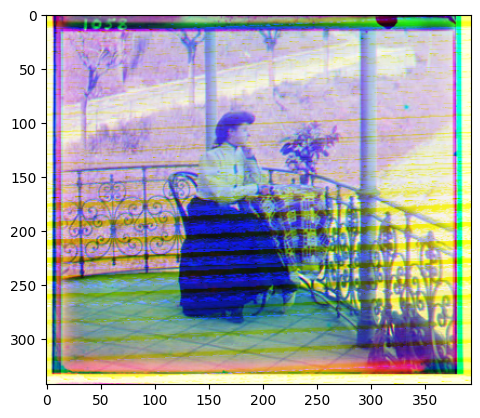

In [218]:
plt.imshow(res)
plt.show()